In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download tongpython/cat-and-dog

cat-and-dog.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip /content/cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import cv2
import os
import re
import PIL
import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout

from time import perf_counter, sleep

In [ ]:
directory_train = '/content/training_set/training_set'
directory_validation = '/content/test_set/test_set'

In [ ]:
class_names = os.listdir(directory_train)
class_names

['cats', 'dogs']

In [ ]:
category_count = []

for root, dirs, files in os.walk(directory_train):
    for dir_path in dirs:
        category_count.append((dir_path, len(os.listdir(root+os.sep+dir_path))))

count_df = pd.DataFrame(category_count, columns=['Classes', 'Total_Images'])
count_df


,Classes,Total_Images
0,cats,4001
1,dogs,4006


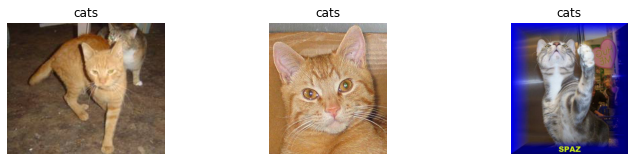

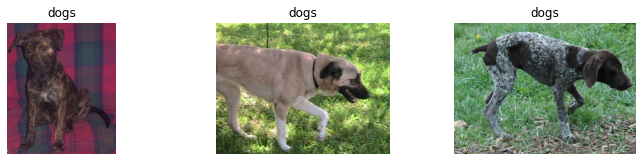

In [ ]:
for name in class_names:
    path = directory_train + "/" + name + "/"
    imagesList = os.listdir(path)
    plt.figure(figsize=(10, 6), constrained_layout=True)
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        img = mpimg.imread(path+imagesList[i])
        plt.imshow(img)
        title = re.sub(r"[_]+","_",name)
        plt.title(title)
        plt.axis("off")


In [ ]:
img = mpimg.imread("/content/training_set/training_set/cats/cat.1.jpg")
img.shape

(280, 300, 3)

In [ ]:
batch_size = 8
IMG_SHAPE = 224

image_gen_train = ImageDataGenerator(rescale=1./255,
                                     rotation_range=45,
                                     width_shift_range=.15,
                                     height_shift_range=.15,
                                     horizontal_flip=True,
                                     zoom_range=0.5
                                    )

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=directory_train,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='categorical'
)

val_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=directory_validation,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='categorical'
)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


In [ ]:
num_classes = len(class_names)

model = Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', 
                           padding = 'same', input_shape=(IMG_SHAPE,IMG_SHAPE,3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
    
    # Adding dropout to turn down some neurons
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dropout (Dropout)           (None, 200704)            0

In [ ]:
#tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

epochs = 10

start = perf_counter()
history = model.fit_generator(train_data_gen,
                              steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
                              epochs=epochs,
                              validation_data=val_data_gen,
                              validation_steps=int(np.ceil(val_data_gen.n / float(batch_size)))
                             )
end = perf_counter()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if sys.path[0] == '':


Epoch 1/10
1001/1001 [==============================] - 145s 132ms/step - loss: 0.6695 - accuracy: 0.5906 - val_loss: 0.6150 - val_accuracy: 0.6733
Epoch 2/10
1001/1001 [==============================] - 130s 129ms/step - loss: 0.6212 - accuracy: 0.6537 - val_loss: 0.6098 - val_accuracy: 0.6599
Epoch 3/10
1001/1001 [==============================] - 130s 129ms/step - loss: 0.5998 - accuracy: 0.6708 - val_loss: 0.5913 - val_accuracy: 0.6851
Epoch 4/10
1001/1001 [==============================] - 129s 129ms/step - loss: 0.5845 - accuracy: 0.6853 - val_loss: 0.5919 - val_accuracy: 0.6728
Epoch 5/10
1001/1001 [==============================] - 129s 129ms/step - loss: 0.5745 - accuracy: 0.6961 - val_loss: 0.5786 - val_accuracy: 0.6930
Epoch 6/10
1001/1001 [==============================] - 129s 129ms/step - loss: 0.5678 - accuracy: 0.7027 - val_loss: 0.5646 - val_accuracy: 0.7054
Epoch 7/10
1001/1001 [==============================] - 129s 129ms/step - loss: 0.5643 - accuracy: 0.7074 - val_

In [ ]:
print(f"Time taken to execute code : {(end-start)/60}")

Time taken to execute code : 21.986356930783334


In [ ]:
model.save("model_cats_dogs.h5")

NameError: ignored

In [ ]:
model = tf.keras.models.load_model('model_cats_dogs.h5')

OSError: ignored

In [ ]:
accuracy_score = model.evaluate(val_data_gen)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))

print("Loss: ",accuracy_score[0])


253/253 [==============================] - 26s 101ms/step - loss: 0.5718 - accuracy: 0.7029
[0.5717776417732239, 0.7029164433479309]
Accuracy: 70.2916%
Loss:  0.5717776417732239


Text(0.5, 1.0, '\nTraining and Validation Accuracy. \nTrain Accuracy: 0.7183010578155518 \nValidation Accuracy: 0.7078596353530884')

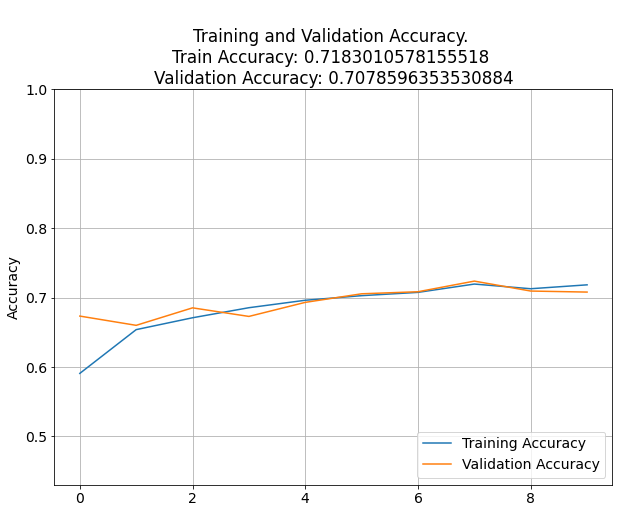

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(10, 16))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.43,1.0])
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {(str(acc[-1]))} \nValidation Accuracy: {str(val_acc[-1])}')


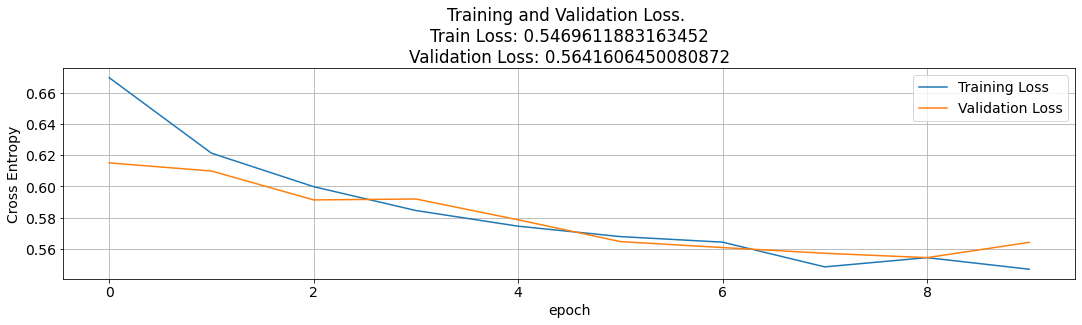

In [ ]:
# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
from keras.preprocessing import image

def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


In [ ]:
# image path
## Cat
#img_path = '/content/test_set/test_set/cats/cat.4004.jpg' 

## Dog
img_path = '/content/test_set/test_set/dogs/dog.4004.jpg'     

# load a single image
new_image = load_image(img_path)

# check prediction
pred = model.predict(new_image)

In [ ]:
class_names

['cats', 'dogs']

In [ ]:
pred

array([[0.1695296, 0.8304704]], dtype=float32)

In [ ]:
class_names[np.argmax(pred)]

'dogs'